# K-Means Clustering

*K-means clustering* is an unsupervised learning technique that groups collections of feature observations together into a pre-specified number of groups.

In this chapter we will perform k-means clustering to backtest data of a volatility trading strategy applied to various ETF underlyings.  In particular, we will cluster the underlyings based on `beta`/`pnl`.  In the related homework assignment, you will be asked to perform clustering by `beta`/`stdev` as well as `stdev`/`pnl`.

## Importing Packages

Let's begin by importing the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

## Reading-In Data

Next let's read-in our data, which consists of performance statistics of the various underlyings over the backtest period.  In particular, we will be interested in:

1. pnl - daily average pnl (multplied by 100)
2. beta - the beta to the strategy applied to SPY (not SPY itself)
3. stdev - the standard deviation of the daily PNLs.

In [ ]:
df_cluster = pd.read_csv("strategy.csv")
df_cluster.head()

,underlying,stdev,spy_stdev,corr_spy,beta,pnl
0,DIA,0.010383,0.014772,0.824586,0.579557,0.613557
1,EEM,0.025753,0.014772,0.550046,0.958898,0.457594
2,EFA,0.021988,0.014772,0.608328,0.905449,-0.582501
3,EMB,0.005283,0.014772,0.185949,0.066495,-0.117455
4,EWH,0.037914,0.014772,0.134310,0.344708,0.036128


We will also import some additional information about the universe of underlyings which we will find useful later in our analysis.

In [ ]:
df_universe = df_cluster[['underlying']]
df = pd.read_csv('universe.csv')
df_universe = df_universe.merge(df, how='inner', on='underlying')
df_universe.head()

,underlying,name
0,DIA,SPDR DOW JONES INDL AVERAGE ET UT SER 1
1,EEM,ISHARES TR MSCI EMG MKT ETF
2,EFA,ISHARES TR MSCI EAFE ETF
3,EMB,ISHARES TR JPMORGAN USD EMG
4,EWH,ISHARES INC MSCI HONG KG ETF


## Checking for Outliers

Let's plot our data quickly in order to check for potential outliers.

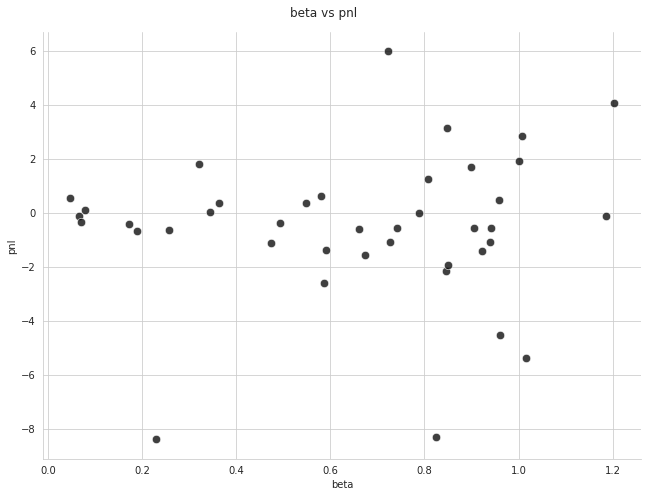

In [ ]:
with sns.axes_style('whitegrid'):
    g = sns.relplot(
            x='beta'
            , y='pnl'
            , data=df_cluster
            , color = 'black'
            , alpha = 0.75
            , height=7 
            , aspect=1.3
            , s=70
        );
    plt.subplots_adjust(top=0.93);
    g.fig.suptitle('beta vs pnl');

## Wrangling: Removing Outliers

There seem to be a few extreme data point, which is likely the result of bad data. Let's write a query to isolate these.

In [ ]:
df_cluster.query("pnl < -8 or pnl > 5")

,underlying,stdev,spy_stdev,corr_spy,beta,pnl
13,GDX,0.061813,0.014772,0.197046,0.824502,-8.315433
19,SLV,0.048230,0.014772,0.221409,0.722864,5.975203
23,UNG,0.082083,0.014772,0.041565,0.230951,-8.397742


We can see that the offenders are GDX, SLV, and UNG.  Let's remove these manually now.

In [ ]:
df_cluster = df_cluster[~df_cluster['underlying'].isin(['UNG', 'SLV', 'GDX'])].reset_index(drop=True)
df_cluster.head()

,underlying,stdev,spy_stdev,corr_spy,beta,pnl
0,DIA,0.010383,0.014772,0.824586,0.579557,0.613557
1,EEM,0.025753,0.014772,0.550046,0.958898,0.457594
2,EFA,0.021988,0.014772,0.608328,0.905449,-0.582501
3,EMB,0.005283,0.014772,0.185949,0.066495,-0.117455
4,EWH,0.037914,0.014772,0.134310,0.344708,0.036128


Let's regraph our cleaned data.

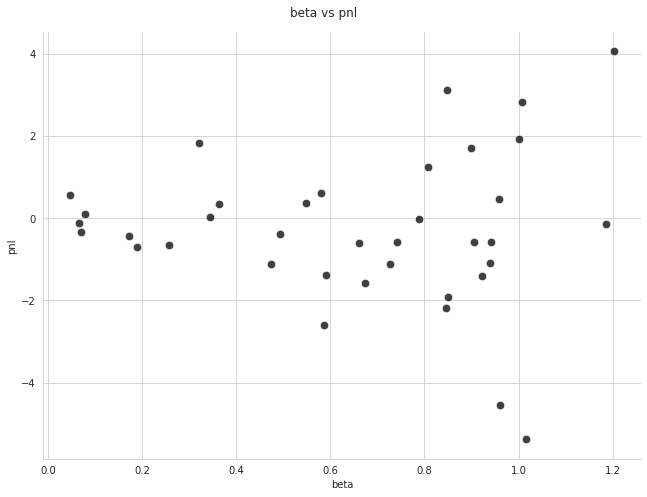

In [ ]:
with sns.axes_style('whitegrid'):
    g = sns.relplot(
            x='beta'
            , y='pnl'
            , data=df_cluster
            , color = 'black'
            , alpha = 0.75
            , height=7 
            , aspect=1.3
            , s=70
        );
    plt.subplots_adjust(top=0.93);
    g.fig.suptitle('beta vs pnl');

---

**Discussion Question:** Inspect the graph above and see if you can predict a K-means clustering based on four clusters.

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
#

---

## K-Means Clustering - First Try

We are now ready to fit our clustering model.  We begin by importing the `KMeans` constructor.

In [ ]:
from sklearn.cluster import KMeans

Next, we will isolate the features we want to use for grouping.

In [ ]:
X = df_cluster[['beta', 'pnl']]
X.head()

,beta,pnl
0,0.579557,0.613557
1,0.958898,0.457594
2,0.905449,-0.582501
3,0.066495,-0.117455
4,0.344708,0.036128


We are now ready to fit our clustering model.  I chose to use 4 groups in the hope that the groupings would align with the following categories:

1. high beta, high pnl
1. high beta, low pnl
1. low beta, high pnl
1. low beta, low pnl

In [ ]:
kmeans = KMeans(n_clusters = 4, n_init=100, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=4, n_init=100, random_state=0)

Let's add a column to our original data frame that includes the group number.

In [ ]:
df_cluster['group'] = kmeans.labels_
df_cluster['group'] = df_cluster['group'].apply(str)
df_cluster.sort_values('group').head()

,underlying,stdev,spy_stdev,corr_spy,beta,pnl,group
0,DIA,0.010383,0.014772,0.824586,0.579557,0.613557,0
31,XLU,0.011834,0.014772,0.236587,0.189522,-0.695763,0
30,XLP,0.009352,0.014772,0.408279,0.258476,-0.653215,0
28,XLI,0.018132,0.014772,0.605048,0.742666,-0.576125,0
27,XLF,0.031330,0.014772,0.444355,0.942399,-0.571652,0


And now let's graph our clustering with colors to show the grouping.

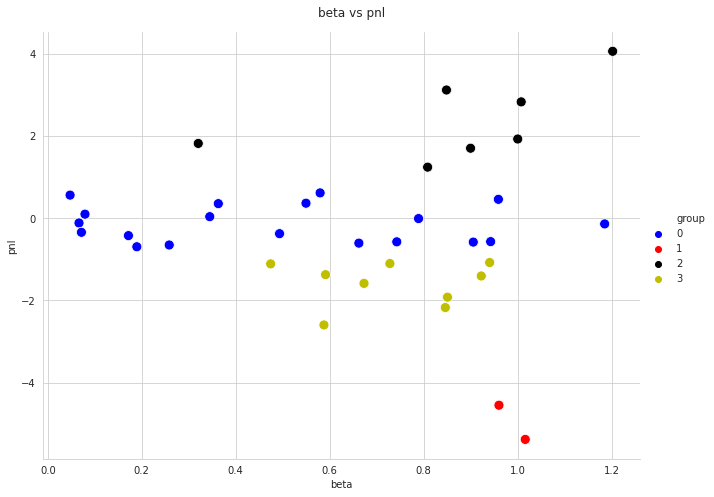

In [ ]:
with sns.axes_style('whitegrid'):
    sns.color_palette("Paired")
    g = sns.relplot(
            x='beta'
            , y='pnl'
            , data=df_cluster
            , height=7 
            , aspect=1.3
            , hue='group'
            , palette=["b", "r", 'k', 'y']
            , s=100
        );
    plt.subplots_adjust(top=0.93);
    g.fig.suptitle('beta vs pnl');

---

**Discussion Question:** What are your observations about this clustering?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# The PNL feature is dominating the clustering because of scale.

--- 

## K-Means Clustering - Second Try

As we can see from the previous section, unless we perform scaling, the `pnl` feature will dominate because its values are an order of magnitude bigger than the `beta` feature. 

So let's scale and perform our analysis again.

In [ ]:
from sklearn.preprocessing import scale
Xs = scale(X)
kmeans = KMeans(n_clusters = 4, n_init=100, random_state=0)
kmeans.fit(Xs)

KMeans(n_clusters=4, n_init=100, random_state=0)

In [ ]:
df_cluster['group'] = kmeans.labels_
df_cluster['group'] = df_cluster['group'].apply(str)
df_cluster = df_cluster.sort_values(['group', 'underlying']).merge(df_universe)
df_cluster.head()

,underlying,stdev,spy_stdev,corr_spy,beta,pnl,group,name
0,EEM,0.025753,0.014772,0.550046,0.958898,0.457594,0,ISHARES TR MSCI EMG MKT ETF
1,EFA,0.021988,0.014772,0.608328,0.905449,-0.582501,0,ISHARES TR MSCI EAFE ETF
2,EWJ,0.025301,0.014772,0.343123,0.587681,-2.597758,0,ISHARES INC MSCI JPN ETF NEW
3,EWU,0.050743,0.014772,0.268563,0.922505,-1.406626,0,ISHARES TR MSCI UK ETF NEW
4,EWW,0.026251,0.014772,0.372520,0.661983,-0.608147,0,ISHARES INC MSCI MEXICO ETF


And let's graph our new grouping.

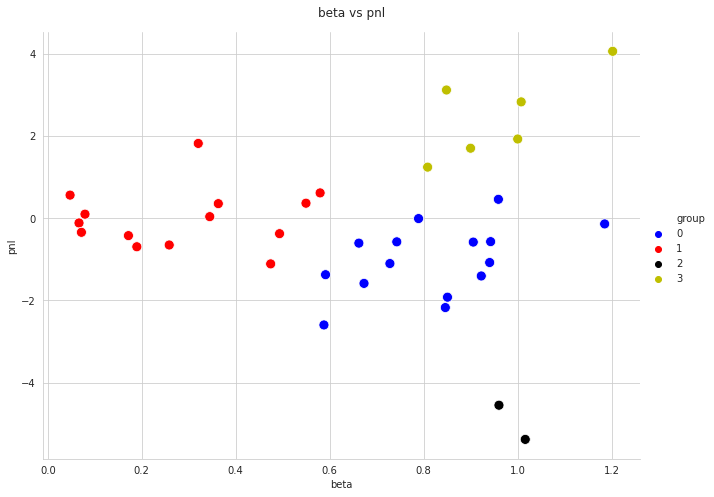

In [ ]:
with sns.axes_style('whitegrid'):
    sns.color_palette("Paired")
    g = sns.relplot(
            x='beta'
            , y='pnl'
            , data=df_cluster
            , height=7 
            , aspect=1.3
            , hue='group'
            , palette=["b", "r", 'k', 'y']
            , s=100
        );
    plt.subplots_adjust(top=0.93);
    g.fig.suptitle('beta vs pnl');

---

**Discussion Question:** What are your observations about this grouping?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# group 0: high beta, zeroish pnl
# group 1: low beta, zeroish pnl
# group 2: extremely low performers
# group 3: high beta, high performers

# group 3 consists of: QQQ, SPY, IWM, USO, EWZ, FXI -- three of these are major stock indices, which is what I would expect
# group 0 contains 7 of the 11 SPDR sector select funds (X--), which makes sense based on what I know of the strategy
# group 0 also contains 5 emerging market related funds (E--), I don't have an opinion on this 

---

**Code Challenge:** Redo the clustering for 3 groups.

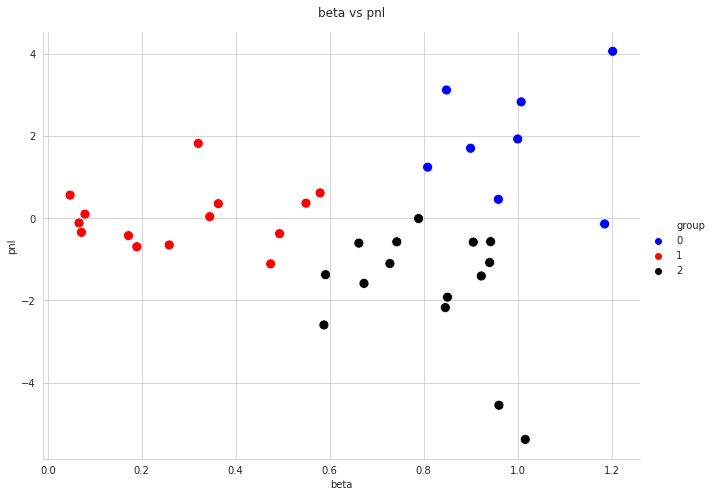

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# fitting
X = df_cluster[['beta', 'pnl']]
Xs = scale(X)
kmeans = KMeans(n_clusters = 3, n_init=100, random_state=0)
kmeans.fit(Xs)
# adding labels to df_cluster
df_cluster['group'] = kmeans.labels_
df_cluster['group'] = df_cluster['group'].apply(str)
df_cluster.sort_values('group')
# graphing
with sns.axes_style('whitegrid'):
    sns.color_palette("Paired")
    g = sns.relplot(
            x='beta'
            , y='pnl'
            , data=df_cluster
            , height=7 
            , aspect=1.3
            , hue='group'
            , palette=["b", "r", 'k']
            , s=100
        );
    plt.subplots_adjust(top=0.93);
    g.fig.suptitle('beta vs pnl');

---